In [1]:
import xgboost as xgb

In [ ]:
xgb.cv()

In [ ]:
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

In [ ]:
import pandas as pd
from utils.plotting import *
from pathlib import Path

In [3]:
metric = "err" # or loss
files = list(Path(f"results/").glob("**/data_imagenet/**/results_all.csv"))

In [4]:
len(files)

285

In [5]:
base_pred = 'torch_linear_lr0.3_wdec1e-06_ep100_bs256'
dino_pred = 'torch_linear_lr0.001_wdec1e-06_ep100_bs256'

results = dict()
sup = dict()

for f in files:
    params = {f.split("_", 1)[0] :f.split("_", 1)[1]  for f in str(f.resolve()).split("results")[1].split("/")[1:-1]}
    if params["data"] != "imagenet":
        continue
    if params["exp"] == "dev":
        continue
    
    metrics = pd.read_csv(f, index_col=0).T[metric]
    key = (params["ssl"].replace("sup_",""), params["pred"], params["seed"])
    
    if "sup_" in params["ssl"]:
        sup[key] = metrics
    else:
        results[key] = metrics

res = results 

results = pd.concat(results, axis=1).T
sup = pd.concat(sup, axis=1).T#.loc[:,["train_train"]]

# reindex such that unique
all_models = results.index.get_level_values(0).unique()
all_pred = results.index.get_level_values(1).unique()
all_seeds = results.index.get_level_values(2).unique()
#results = results.reindex(pd.MultiIndex.from_product([all_models, all_pred, all_seeds], names=['enc', 'pred', "seed"])).dropna()

results.index.set_names(["enc","pred","seed"], inplace=True)
sup.index.set_names(["enc","pred","seed"], inplace=True)

results = results.drop(columns=["pred_gen_01","enc_gen_01","train-cmplmnt-0.1_train","train-cmplmnt-0.1_test"])

# couldn't find supervised pretrained model with that architecture :(
# so simply make it clear in paper by mergine approx and decodability
for model in ['rn50x4', 'rn50x16', 'rn50x64']:
    for seed in ["123","124","125"]:
        sup.loc[(model, base_pred, seed),:] = 0 
        
# TO RM 
# for model in ['vitB32']:
#     for seed in ["123","124","125"]:
#         sup.loc[(model, base_pred, seed),:] = 0 
        
# for model in ['vitS16','vitB16']:
#     for seed in ["123","124","125"]:
#         sup.loc[(model, dino_pred, seed),:] = 0 

results = results * 100
sup = sup * 100


In [6]:
sup

train_train  \
enc         pred                                       seed                
vitB16_dino torch_linear_lr0.001_wdec1e-06_ep100_bs256 125      9.116610   
                                                       123      9.123713   
                                                       124      9.116064   
            torch_linear_lr0.3_wdec1e-06_ep100_bs256   125      0.543957   
                                                       123      0.542942   
...                                                                  ...   
rn50x16     torch_linear_lr0.3_wdec1e-06_ep100_bs256   124      0.000000   
                                                       125      0.000000   
rn50x64     torch_linear_lr0.3_wdec1e-06_ep100_bs256   123      0.000000   
                                                       124      0.000000   
                                                       125      0.000000   

                                                             train_test  \
enc         pred                                       seed               
vitB16_dino torch_linear_lr0.001_wdec1e-06_ep100_bs256 125    16.868000   
                                                       123    16.952001   
                                                       124    17.076001   
            torch_linear_lr0.3_wdec1e-06_ep100_bs256   125    20.384000   
                                                       123    20.340000   
...                                                                 ...   
rn50x16     torch_linear_lr0.3_wdec1e-06_ep100_bs256   124     0.000000   
                                                       125     0.000000   
rn50x64     torch_linear_lr0.3_wdec1e-06_ep100_bs256   123     0.000000   
                                                       124     0.000000   
                                                       125     0.000000   

                                                             train-sbst-0.01_train-sbst-0.01  \
enc         pred                                       seed                                    
vitB16_dino torch_linear_lr0.001_wdec1e-06_ep100_bs256 125                          0.382454   
                                                       123                          0.382454   
                                                       124                          0.296597   
            torch_linear_lr0.3_wdec1e-06_ep100_bs256   125                          0.000000   
                                                       123                          0.000000   
...                                                                                      ...   
rn50x16     torch_linear_lr0.3_wdec1e-06_ep100_bs256   124                          0.000000   
                                                       125                          0.000000   
rn50x64     torch_linear_lr0.3_wdec1e-06_ep100_bs256   123                          0.000000   
                                                       124                          0.000000   
                                                       125                          0.000000   

                                                             train-sbst-0.01_train  \
enc         pred                                       seed                          
vitB16_dino torch_linear_lr0.001_wdec1e-06_ep100_bs256 125                     NaN   
                                                       123                     NaN   
                                                       124                     NaN   
            torch_linear_lr0.3_wdec1e-06_ep100_bs256   125                     NaN   
                                                       123                     NaN   
...                                                                            ...   
rn50x16     torch_linear_lr0.3_wdec1e-06_ep100_bs256   124                     0.0   
                                                       125               

In [7]:
def res_to_sup_name(index):
    enc, pred, seed = index
    
    model, arch, *other = enc.split("_")
    other = "_".join(other)
    
    out = arch
    
    ######## dirty :/ 
    if model in ["beit"]:
        out += f"_{model}"

    if model in ["dino"] and "last" not in other:
        # when you put "dino_last" this means you use standard last extraction
        # but in sup the same is whithout suffix
        out += f"_{model}"
    
    if "extract" in other:
        out += f"_{other}"
    #######     
        
    if out == "rn50_dino":
        out = "rn50"
    elif out == "vitL14":
        out = "vitL16" # don't have 16 so replacve by 14

        
    return (out, pred, seed)

architectures = [res_to_sup_name(i) for i in results.index]
results["approximation"] = sup.loc[architectures, "train_train"].values
results["decodability"] = results["train_train"] - results["approximation"]
# results["sum_components"] = results["approximation"] + results["decodability"] + results["pred_gen"] + results["enc_gen"]
results["agg_risk"] = results["train_test"]
# results["delta"] = results["sum_components"] - results["agg_risk"]

# results["approximation_001"] = sup.loc[architectures, "train-sbst-0.01_train-sbst-0.01"].values 
# results["decodability_001"] = results["train-sbst-0.01_train-sbst-0.01"] - results["approximation_001"]
results["approximation_001"] = results["approximation"] 
results["decodability_001"] = results["decodability"] 
# decodability and approximation are better estimated on entire dataset
# results["sum_components_001"] = results["approximation_001"] + results["decodability_001"] + results["pred_gen_001"] + results["enc_gen_001"]
results["agg_risk_001"] = results["train-sbst-0.01_test"]
# results["delta_001"] = results["sum_components_001"] - results["agg_risk_001"]
results["delta_pred_gen"] = results["pred_gen"] - results["pred_gen_001"]


In [8]:
results

train_train  \
enc                      pred                                         seed                
simclr_rn50              torch_mlpD3W1024_lr0.3_wdec1e-06_ep100_bs256 125      0.460830   
                                                                      123      0.460830   
                                                                      124      0.460908   
                         torch_mlpD2W256_lr0.3_wdec1e-06_ep100_bs256  125      8.068503   
                                                                      123      8.074748   
...                                                                                 ...   
simclr_rn50_bs512_ep100  torch_linear_lr0.3_wdec1e-06_ep100_bs256     123     29.766220   
                                                                      124     29.766923   
simclr_rn50_bs4096_ep100 torch_linear_lr0.3_wdec1e-06_ep100_bs256     125     31.632331   
                                                                      123     31.619531   
                                                                      124     31.625384   

                                                                            train_test  \
enc                      pred                                         seed               
simclr_rn50              torch_mlpD3W1024_lr0.3_wdec1e-06_ep100_bs256 125    33.002001   
                                                                      123    33.131999   
                                                                      124    32.664001   
                         torch_mlpD2W256_lr0.3_wdec1e-06_ep100_bs256  125    36.897999   
                                                                      123    36.632001   
...                                                                                ...   
simclr_rn50_bs512_ep100  torch_linear_lr0.3_wdec1e-06_ep100_bs256     123    40.494001   
                                                                      124    40.518001   
simclr_rn50_bs4096_ep100 torch_linear_lr0.3_wdec1e-06_ep100_bs256     125    38.275999   
                                                                      123    38.330001   
                                                                      124    38.284001   

                                                                            train-cmplmnt-ntest_train-sbst-ntest  \
enc                      pred                                         seed                                         
simclr_rn50              torch_mlpD3W1024_lr0.3_wdec1e-06_ep100_bs256 125                              28.896001   
                                                                      123                              29.266000   
                                                                      124                              29.016000   
                         torch_mlpD2W256_lr0.3_wdec1e-06_ep100_bs256  125                              32.905999   
                                                                      123                              33.513999   
...                                                                                                          ...   
simclr_rn50_bs512_ep100  torch_linear_lr0.3_wdec1e-06_ep100_bs256     123                              37.432000   
                                                                      124                              37.408000   
simclr_rn50_bs4096_ep100 torch_linear_lr0.3_wdec1e-06_ep100_bs256     125                              35.543999   
                                                                      123                              35.543999   
                                                                      124                              35.506001   

                                                                            train-cmplmnt-ntest_test  \
enc                      pred                                         seed                             
simc

In [9]:


results_mean = results.reset_index().groupby(["enc","pred"]).mean() 
results_sem = results.reset_index().groupby(["enc","pred"]).agg("sem") 

all_indcs = list(results.index)
components = ["agg_risk", "approximation", "decodability", "pred_gen", "enc_gen"]
components_001 = [c + "_001" for c in components] + ["delta_pred_gen"]

## Is it a good estimate

In [10]:
#from sklearn.metrics import explained_variance_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt 
from utils.plotting import plot_config
import numpy as np

def evaluate_loss_decomposition(results, components, agg_risk="agg_risk", is_pos=True):
    y_true = results[agg_risk] 
    y_pred = sum(results[comp].clip(lower=0) if is_pos else results[comp]
                 for comp in components 
                 if "agg_risk" not in comp and "delta" not in comp)

    with plot_config():
        fig, ax = plt.subplots()
        ax.scatter(y_pred, y_true)
        xlim = ax.get_xlim()
        ylim = ax.get_ylim()
        ax.plot([0,100],[0,100], color="gray", alpha=0.3, label="x=y")
        ax.set_xlim(xlim)
        ax.set_ylim(ylim)
        ax.set_xlabel("Sum of loss components")
        ax.set_ylabel("Actual agg. error")
        ax.legend()
        
    RMSE = mean_squared_error(y_true, y_pred, squared=False)
    R2 = r2_score(y_true, y_pred)

    print(f"Over entire dataset ({len(y_true)} models) your R2 is {R2:.4f}, RMSE is {RMSE:.4f}.")

Over entire dataset (172 models) your R2 is 0.9998, RMSE is 0.1594.


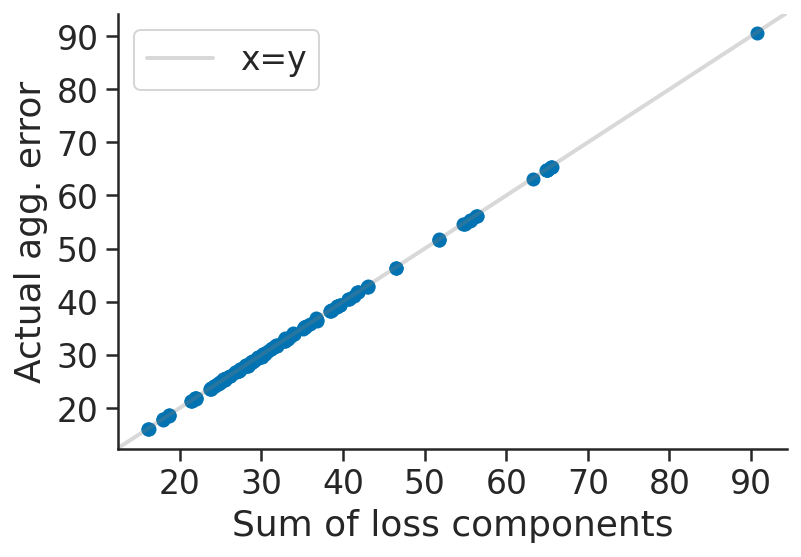

In [11]:
evaluate_loss_decomposition(results, components, agg_risk="agg_risk", is_pos=True)

171
Over entire dataset (171 models) your R2 is 1.0000, RMSE is 0.0202.


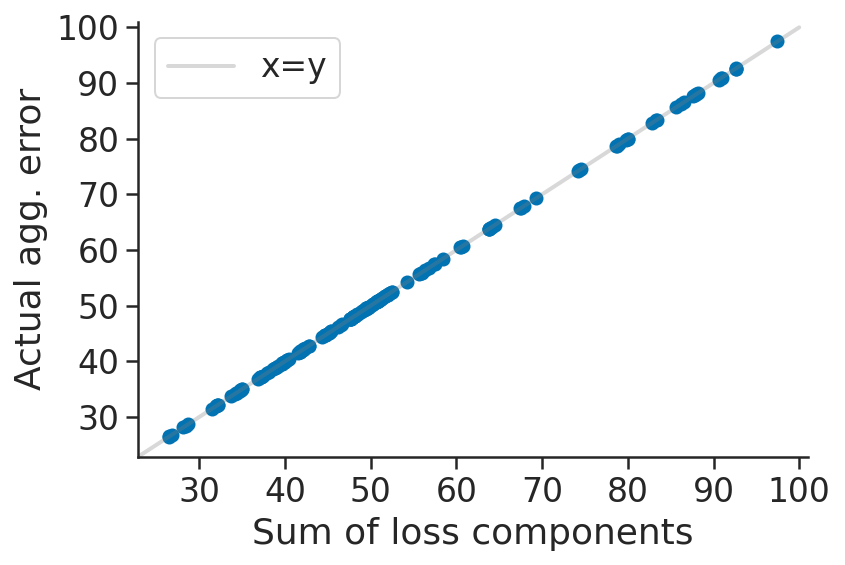

In [12]:
# now for 1% of data
results_001 = results[~results["agg_risk_001"].isna()]
print(len(results_001))
evaluate_loss_decomposition(results_001, components_001, agg_risk="agg_risk_001", is_pos=True)

## Prepare

In [13]:
# compute mean and sem over seeds for each estiamte
results_mean = results.reset_index().groupby(["enc","pred"]).mean()
results_sem = results.reset_index().groupby(["enc","pred"]).agg("sem")



## Epochs

these should really be line charts if decodability is the only thing changing


In [14]:
curr_components = components


curr_models = [f"swav_rn50_ep{e}00" for e in [1,2,4]] 
epochs = [100,200,400]

curr_models += ["swav_rn50"]
epochs += [800]

curr_models += ["simclr_rn50_bs4096_ep100"] + [f"simclr_rn50_ep{i}00" for i in [2,4,8]] + ["simclr_rn50"] 
epochs += [100,200,400,800,1000]

curr_models += ["simclr_rn50w2_ep100"] + [f"simclr_rn50w2"] 
epochs += [100,1000]

curr_models += ["simclr_rn101_ep100"] + [f"simclr_rn101"] 
epochs += [100,1000]

curr_models += ["pirl_rn50_ep200"] + [f"pirl_rn50"] 
epochs += [200,800]

curr_models += ["barlow_rn50_ep300"] + [f"barlow_rn50"] 
epochs += [300,1000]

# curr_models += [f"mocov3_rn50_ep{e}00" for e in [3]] 
# epochs += [300]

curr_idx = [(m,base_pred) for m in curr_models]

results_epochs = (results_mean.loc[curr_idx, curr_components] 
).round(decimals=2)#.sort_values("agg_risk", ascending=False)

results_epochs["model"] = ["_".join(enc.split("_")[0:2]) for enc in results_epochs.index.get_level_values("enc") ]
results_epochs["epochs"] = epochs

grouped_results = results_epochs.set_index(["model","epochs"])
grouped_results

agg_risk  approximation  decodability  pred_gen  enc_gen
model         epochs                                                          
swav_rn50     100        30.14           6.31         16.63      4.24     3.08
              200        28.04           6.31         14.13      4.67     3.00
              400        27.30           6.31         13.49      4.27     3.34
              800        26.71           6.31         13.05      4.23     3.22
simclr_rn50   100        38.30           6.31         25.32      3.91     2.93
              200        36.54           6.31         24.26      3.27     2.83
              400        35.88           6.31         24.03      2.46     3.19
              800        35.20           6.31         24.01      2.06     2.94
              1000       31.76           6.31         16.90      5.09     3.56
simclr_rn50w2 100        33.49           1.69         25.39      3.39     3.17
              1000       29.50           1.69         23.04      1.35     3.49
simclr_rn101  100        35.39           4.45         24.00      4.06     2.93
              1000       31.66           4.45         22.53      1.39     3.37
pirl_rn50     200        41.12           6.31         27.52      4.56     2.98
              800        39.10           6.31         26.28      3.77     2.91
barlow_rn50   300        30.74           6.31         17.04      4.24     3.26
              1000       29.41           6.31         15.42      4.28     3.52

In [19]:
results_sem.loc[results_epochs.index, curr_components].round(decimals=2)

,,agg_risk,approximation,decodability,pred_gen,enc_gen
enc,pred,,,,,
swav_rn50_ep100,torch_linear_lr0.3_wdec1e-06_ep100_bs256,0.01,0.0,0.00,0.03,0.04
swav_rn50_ep200,torch_linear_lr0.3_wdec1e-06_ep100_bs256,0.01,0.0,0.00,0.07,0.07
swav_rn50_ep400,torch_linear_lr0.3_wdec1e-06_ep100_bs256,0.03,0.0,0.01,0.15,0.17
swav_rn50,torch_linear_lr0.3_wdec1e-06_ep100_bs256,0.00,0.0,0.00,0.03,0.05
simclr_rn50_bs4096_ep100,torch_linear_lr0.3_wdec1e-06_ep100_bs256,0.02,0.0,0.01,0.01,0.02
simclr_rn50_ep200,torch_linear_lr0.3_wdec1e-06_ep100_bs256,NaN,NaN,NaN,NaN,NaN
simclr_rn50_ep400,torch_linear_lr0.3_wdec1e-06_ep100_bs256,NaN,NaN,NaN,NaN,NaN
simclr_rn50_ep800,torch_linear_lr0.3_wdec1e-06_ep100_bs256,NaN,NaN,NaN,NaN,NaN
simclr_rn50,torch_linear_lr0.3_wdec1e-06_ep100_bs256,0.01,0.0,0.00,0.05,0.06


#### Line Plots

In [82]:
results_to_plot = results.copy().loc[(np.array(curr_idx)[:,0],np.array(curr_idx)[:,1],slice(None)),curr_components]
results_to_plot = results_to_plot.join(results_epochs.drop(components,axis=1))
results_to_plot = results_to_plot.reset_index().set_index(["enc","epochs","seed"])
results_to_plot = results_to_plot.groupby("model").transform(lambda x: (x - x.min()) / (x.max() - x.min()) ).reset_index()
results_to_plot["model"] = ["_".join(enc.split("_")[0:2]) for enc in results_to_plot["enc"]]

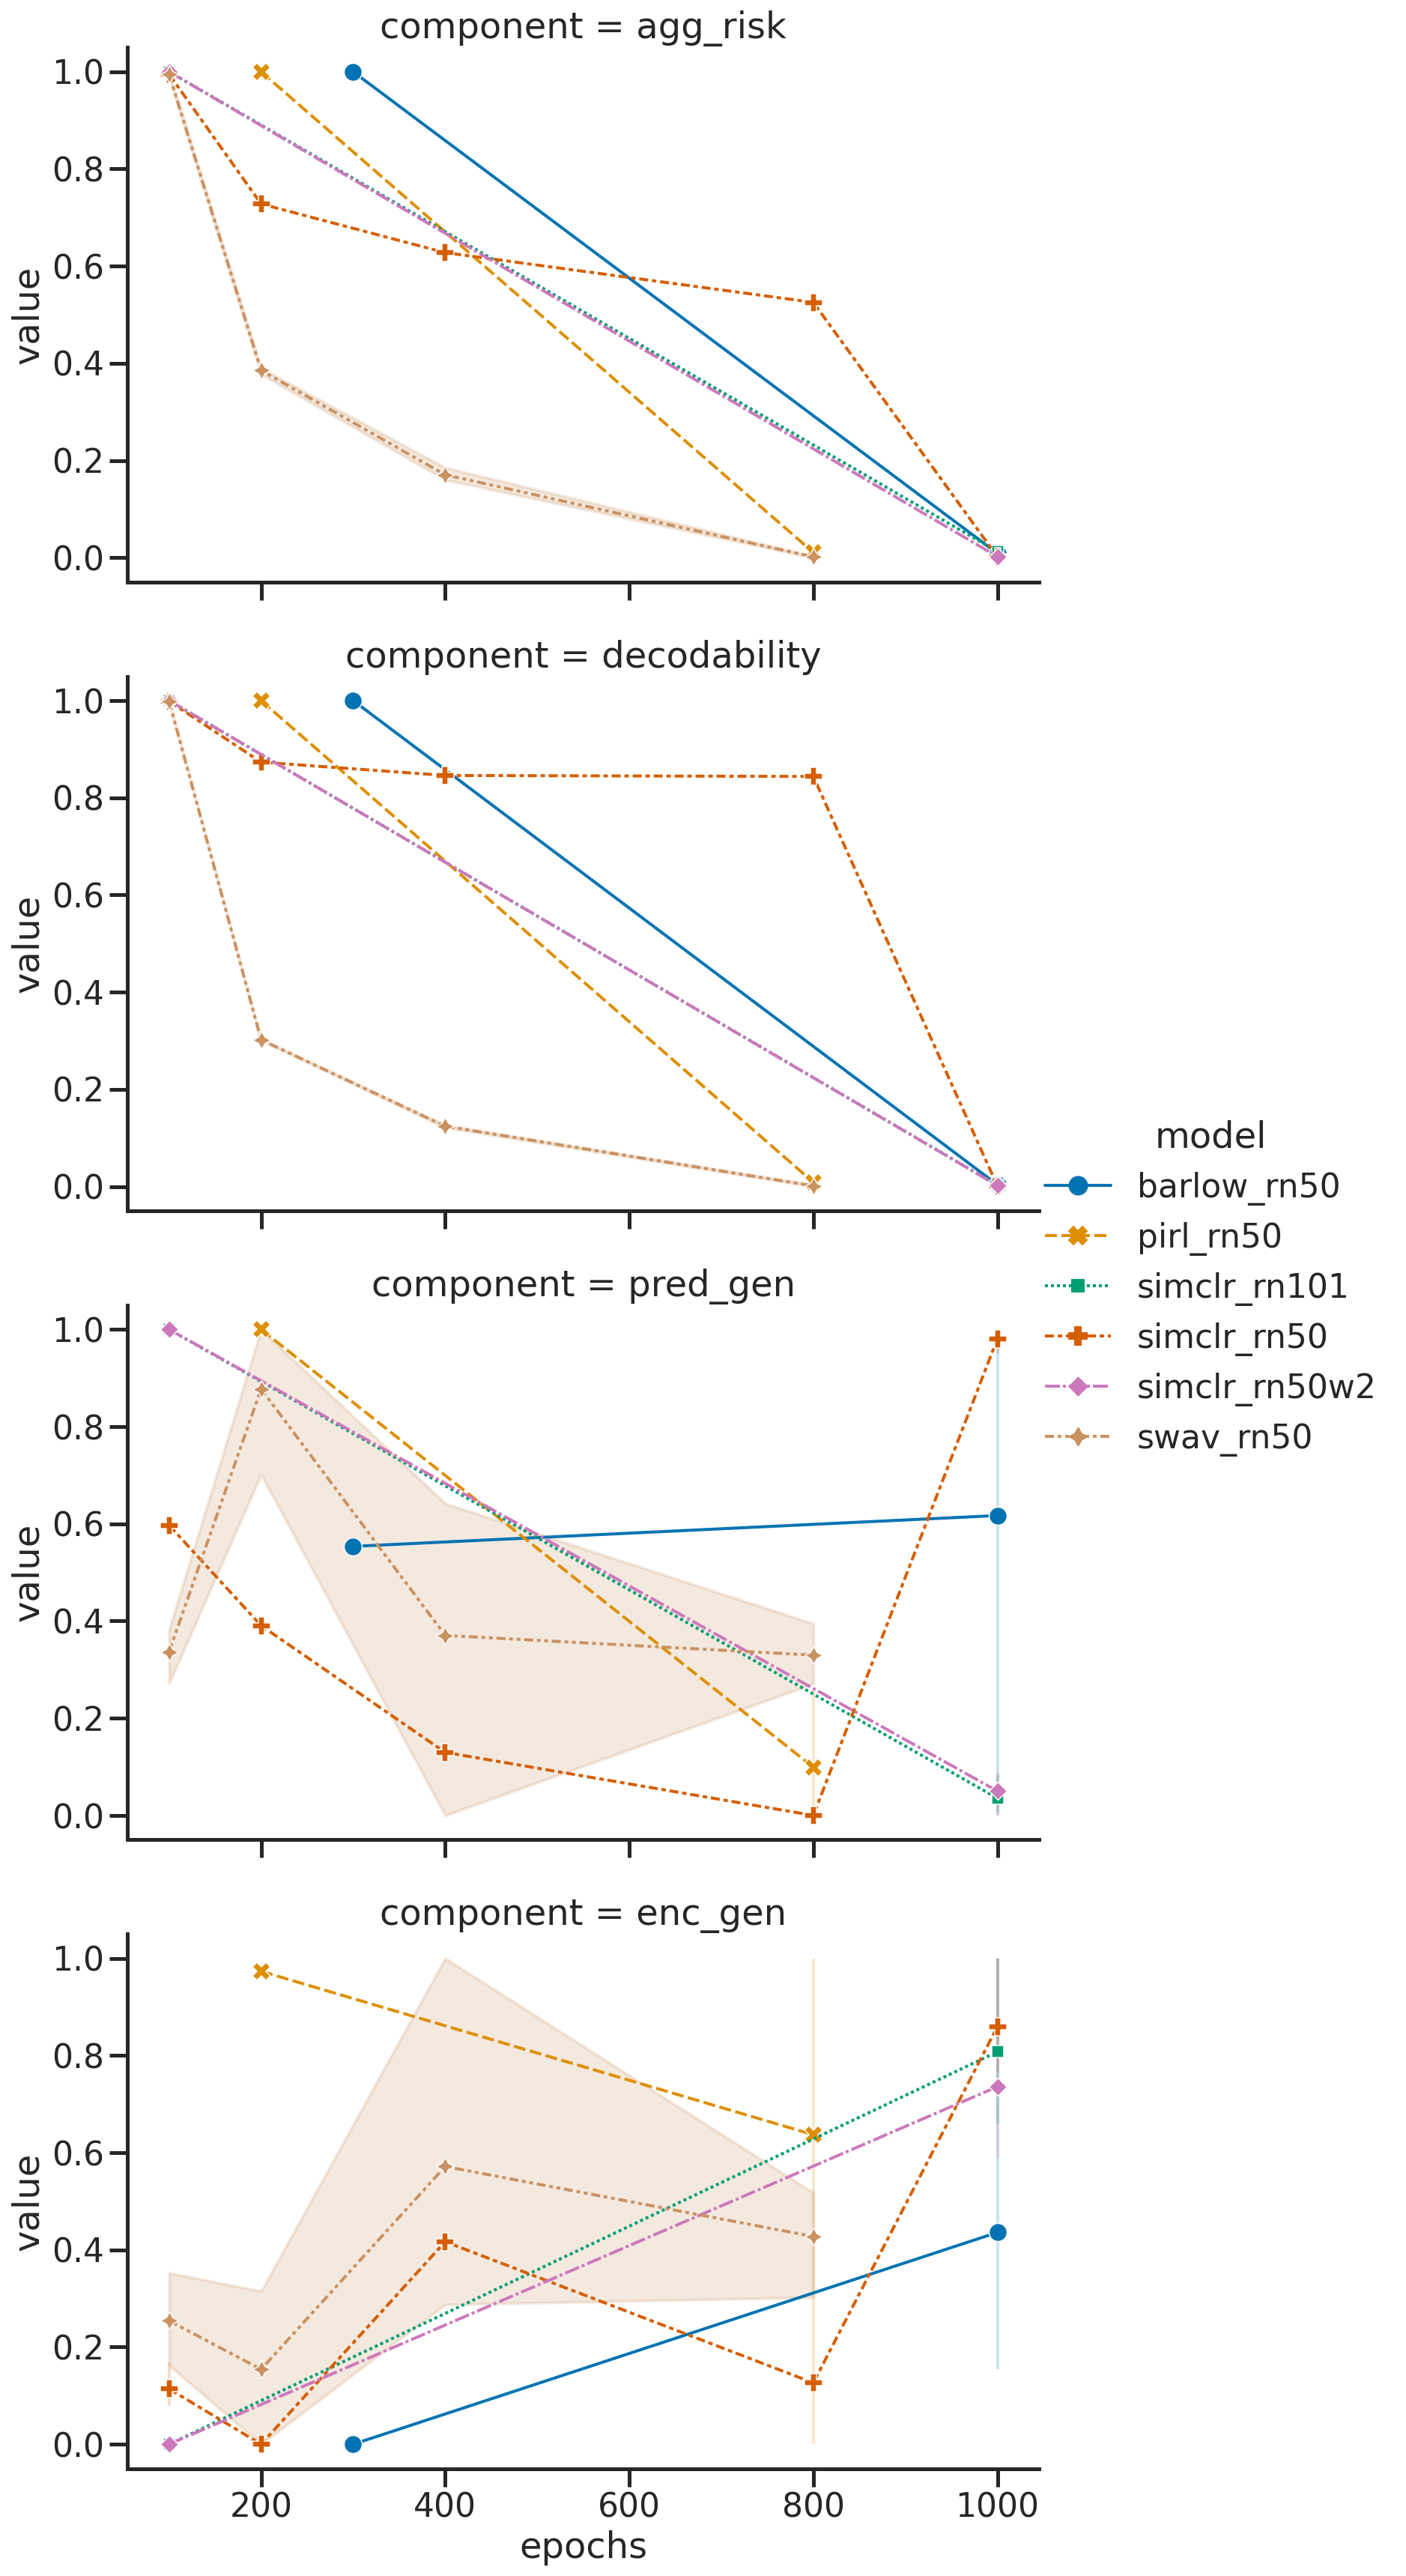

In [84]:
with plot_config(font_scale=1, context='poster'):
    value_vars = [c for c in components if c != "approximation"]
    res_to_plot = results_to_plot.reset_index().melt(id_vars=["model","epochs"],
                                                     value_vars=value_vars,var_name='component')
    sns.relplot(data=res_to_plot, hue="model", style="model", x="epochs",y="value", kind="line",
                height=6, aspect=10/6, markers=True,row="component",facet_kws={
                    "sharey": False,
                    "sharex": True,
                    "legend_out": True,
                },)

## Data

In [90]:
curr_components = components


curr_models = [f"rotnet_rn50_in{i}k" for i in [1,22]] 
data = ["1k","22k"]

curr_models += ["jigsaw_rn50","jigsaw_rn50_in22k"]
data += ["1k","22k"]

curr_idx = [(m,base_pred) for m in curr_models]

results_data = (results_mean.loc[curr_idx, curr_components] 
).round(decimals=2)#.sort_values("agg_risk", ascending=False)

results_data["model"] = ["_".join(enc.split("_")[0:2]) for enc in results_data.index.get_level_values("enc") ]
results_data["data"] = data

grouped_results = results_data.set_index(["model","data"])
grouped_results

agg_risk  approximation  decodability  pred_gen  enc_gen
model       data                                                          
rotnet_rn50 1k       64.84           6.31         52.43      3.55     2.70
            22k      56.15           6.31         41.33      5.14     3.62
jigsaw_rn50 1k       64.76           6.31         47.91      7.18     3.57
            22k      63.14           6.31         49.09      4.60     3.31

In [91]:
curr_components = components

curr_idx = [(m,base_pred) for m in curr_models]

results_data = (results_mean.loc[curr_idx, curr_components]
).round(decimals=2).sort_values("agg_risk", ascending=False)

results_data

,,agg_risk,approximation,decodability,pred_gen,enc_gen
enc,pred,,,,,
rotnet_rn50_in1k,torch_linear_lr0.3_wdec1e-06_ep100_bs256,64.84,6.31,52.43,3.55,2.70
jigsaw_rn50,torch_linear_lr0.3_wdec1e-06_ep100_bs256,64.76,6.31,47.91,7.18,3.57
jigsaw_rn50_in22k,torch_linear_lr0.3_wdec1e-06_ep100_bs256,63.14,6.31,49.09,4.60,3.31
rotnet_rn50_in22k,torch_linear_lr0.3_wdec1e-06_ep100_bs256,56.15,6.31,41.33,5.14,3.62


## Batch size

In [ ]:
curr_components = components

curr_models = [f"simclr_rn50_bs{i}_ep100" for i in [512,4096]] 
batch_size = [512,4096]

curr_models += ["swav_rn50_ep400_bs256","swav_rn50_ep400"] 
batch_size += [256,4096]

curr_models += ["swav_rn50_ep200_bs256","swav_rn50_ep200"] 
batch_size += [256,4096]

curr_idx = [(m,base_pred) for m in curr_models]

results_bs = (results_mean.loc[curr_idx, curr_components] 
).round(decimals=2)#.sort_values("agg_risk", ascending=False)

results_bs["model"] = ["_".join(enc.split("_")[0:2]) for enc in results_bs.index.get_level_values("enc") ]
results_bs["batch_size"] = batch_size

grouped_results = results_bs.set_index(["model","batch_size"])
grouped_results

In [23]:
results_sem.loc[results_bs.index, curr_components].round(decimals=2)

,,agg_risk,approximation,decodability,pred_gen,enc_gen
enc,pred,,,,,
simclr_rn50_bs512_ep100,torch_linear_lr0.3_wdec1e-06_ep100_bs256,0.02,0.0,0.00,0.01,0.02
simclr_rn50_bs4096_ep100,torch_linear_lr0.3_wdec1e-06_ep100_bs256,0.02,0.0,0.01,0.01,0.02


## Algorithms

In [24]:
curr_components = components
curr_models = [m for m in all_models if m.endswith("_rn50")]  + ['rotnet_rn50_in1k']
curr_idx = [(m,base_pred) for m in curr_models]

results_alg = (results_mean.loc[curr_idx, curr_components] 
).round(decimals=2).sort_values("agg_risk", ascending=False)

results_alg

,,agg_risk,approximation,decodability,pred_gen,enc_gen
enc,pred,,,,,
rotnet_rn50_in1k,torch_linear_lr0.3_wdec1e-06_ep100_bs256,64.84,6.31,52.43,3.55,2.70
jigsaw_rn50,torch_linear_lr0.3_wdec1e-06_ep100_bs256,64.76,6.31,47.91,7.18,3.57
clusterfit_rn50,torch_linear_lr0.3_wdec1e-06_ep100_bs256,54.62,6.31,11.67,33.49,3.36
npid_rn50,torch_linear_lr0.3_wdec1e-06_ep100_bs256,51.66,6.31,37.28,5.00,3.17
npidpp_rn50,torch_linear_lr0.3_wdec1e-06_ep100_bs256,46.28,6.31,31.09,5.76,3.28
pirl_rn50,torch_linear_lr0.3_wdec1e-06_ep100_bs256,39.10,6.31,26.28,3.77,2.91
simclr_rn50,torch_linear_lr0.3_wdec1e-06_ep100_bs256,31.76,6.31,16.90,5.09,3.56
barlow_rn50,torch_linear_lr0.3_wdec1e-06_ep100_bs256,29.41,6.31,15.42,4.28,3.52
clip_rn50,torch_linear_lr0.3_wdec1e-06_ep100_bs256,27.94,6.31,17.39,2.17,2.16


In [45]:
results_sem.loc[results_alg.index, curr_components].round(decimals=2)

,,agg_risk,approximation,decodability,pred_gen,enc_gen
enc,pred,,,,,
rotnet_rn50_in1k,torch_linear_lr0.3_wdec1e-06_ep100_bs256,0.02,0.0,0.01,0.05,0.06
jigsaw_rn50,torch_linear_lr0.3_wdec1e-06_ep100_bs256,0.03,0.0,0.00,0.05,0.04
clusterfit_rn50,torch_linear_lr0.3_wdec1e-06_ep100_bs256,0.01,0.0,0.00,0.06,0.13
npid_rn50,torch_linear_lr0.3_wdec1e-06_ep100_bs256,0.04,0.0,0.01,0.09,0.07
npidpp_rn50,torch_linear_lr0.3_wdec1e-06_ep100_bs256,0.02,0.0,0.01,0.11,0.11
pirl_rn50,torch_linear_lr0.3_wdec1e-06_ep100_bs256,0.01,0.0,0.01,0.07,0.07
simclr_rn50,torch_linear_lr0.3_wdec1e-06_ep100_bs256,0.01,0.0,0.00,0.09,0.08
barlow_rn50,torch_linear_lr0.3_wdec1e-06_ep100_bs256,0.01,0.0,0.00,0.17,0.17
clip_rn50,torch_linear_lr0.3_wdec1e-06_ep100_bs256,0.01,0.0,0.00,0.07,0.05


## Architectures

#### CLIP

this is the best comparison for architectures as they all use the same predictor and feature extraction (last)

In [94]:
curr_components = components
curr_models = [m for m in all_models if m.startswith("clip_")]
curr_idx = [(m,base_pred) for m in curr_models]

results_arch_clip = (results_mean.loc[curr_idx, curr_components] 
).round(decimals=2).sort_values("agg_risk", ascending=False)
results_arch_clip

,,agg_risk,approximation,decodability,pred_gen,enc_gen
enc,pred,,,,,
clip_rn50,torch_linear_lr0.3_wdec1e-06_ep100_bs256,27.94,6.31,17.39,2.17,2.16
clip_vitB32,torch_linear_lr0.3_wdec1e-06_ep100_bs256,25.64,2.31,9.95,10.86,2.57
clip_rn101,torch_linear_lr0.3_wdec1e-06_ep100_bs256,24.53,4.45,15.40,2.48,2.30
clip_rn50x4,torch_linear_lr0.3_wdec1e-06_ep100_bs256,21.79,0.00,16.35,3.25,2.31
clip_vitB16,torch_linear_lr0.3_wdec1e-06_ep100_bs256,21.35,1.08,7.99,9.85,2.51
clip_rn50x16,torch_linear_lr0.3_wdec1e-06_ep100_bs256,18.57,0.00,12.65,3.72,2.27
clip_vitL14,torch_linear_lr0.3_wdec1e-06_ep100_bs256,17.83,0.58,3.12,12.00,2.24
clip_rn50x64,torch_linear_lr0.3_wdec1e-06_ep100_bs256,16.09,0.00,8.25,5.81,2.09


In [95]:
results_sem.loc[results_arch_clip.index, curr_components].round(decimals=2)

,,agg_risk,approximation,decodability,pred_gen,enc_gen
enc,pred,,,,,
clip_rn50,torch_linear_lr0.3_wdec1e-06_ep100_bs256,0.01,0.0,0.0,0.07,0.05
clip_vitB32,torch_linear_lr0.3_wdec1e-06_ep100_bs256,0.01,0.0,0.0,0.03,0.03
clip_rn101,torch_linear_lr0.3_wdec1e-06_ep100_bs256,0.02,0.0,0.0,0.05,0.03
clip_rn50x4,torch_linear_lr0.3_wdec1e-06_ep100_bs256,0.01,0.0,0.0,0.07,0.09
clip_vitB16,torch_linear_lr0.3_wdec1e-06_ep100_bs256,0.01,0.0,0.0,0.06,0.11
clip_rn50x16,torch_linear_lr0.3_wdec1e-06_ep100_bs256,0.01,0.0,0.0,0.03,0.03
clip_vitL14,torch_linear_lr0.3_wdec1e-06_ep100_bs256,0.01,0.0,0.0,0.02,0.02
clip_rn50x64,torch_linear_lr0.3_wdec1e-06_ep100_bs256,0.01,0.0,0.0,0.05,0.02


#### Resnet

In [100]:
curr_components = components

curr_models = ["simclr_rn50","simclr_rn101","simclr_rn50w2"] 
nparam = [24,43,94]

# curr_models = ["simclr_rn50","simclr_rn101","simclr_rn50w2","simclr_rn50w4"] 
# nparam = [24,43,94,375]

# curr_models += ["npidpp_rn50","npidpp_rn50w2"] 
# nparam += [24,94]

# curr_models += ["swav_rn50","swav_rn50w2","swav_rn50w4","swav_rn50w5"] 
# nparam += [24,94,375,586]


curr_idx = [(m,base_pred) for m in curr_models]

results_arch_rn = (results_mean.loc[curr_idx, curr_components] 
).round(decimals=2)#.sort_values("agg_risk", ascending=False)

results_arch_rn["model"] = [enc.split("_")[0] for enc in results_arch_rn.index.get_level_values("enc") ]
results_arch_rn["arch"] = [enc.split("_")[1] for enc in results_arch_rn.index.get_level_values("enc") ]
results_arch_rn["nparam"] = nparam

grouped_results = results_arch_rn.set_index(["model","arch","nparam"])
grouped_results

agg_risk  approximation  decodability  pred_gen  enc_gen
model  arch   nparam                                                          
simclr rn50   24         31.76           6.31         16.90      5.09     3.56
       rn101  43         31.66           4.45         22.53      1.39     3.37
       rn50w2 94         29.50           1.69         23.04      1.35     3.49

In [49]:
results_sem.loc[results_arch_rn.index, curr_components].round(decimals=2)

,,agg_risk,approximation,decodability,pred_gen,enc_gen
enc,pred,,,,,
simclr_rn50,torch_linear_lr0.3_wdec1e-06_ep100_bs256,0.01,0.0,0.0,0.09,0.08
simclr_rn101,torch_linear_lr0.3_wdec1e-06_ep100_bs256,0.02,0.0,0.0,0.07,0.05
simclr_rn50w2,torch_linear_lr0.3_wdec1e-06_ep100_bs256,0.01,0.0,0.0,0.06,0.06


#### Vision transformer

In [50]:
# NOTE: this seems very unintuitive but actually intuitive once you realize that VIt b 16 is evaluated differently int ath you use less tokens
# should change to all be last with standard eval

In [51]:
curr_components = components
curr_idx = [i for i in results_mean.index if i[0].startswith("dino_") and i[0].endswith("_last")] + [("dino_rn50",base_pred)]

results_arch_dino =  (results_mean.loc[curr_idx, curr_components]
).round(decimals=2).sort_values("agg_risk", ascending=False)

results_arch_dino

,,agg_risk,approximation,decodability,pred_gen,enc_gen
enc,pred,,,,,
dino_vitB16_last,torch_linear_lr0.3_wdec1e-06_ep100_bs256,28.58,1.08,7.51,15.51,4.60
dino_vitS16_last,torch_linear_lr0.3_wdec1e-06_ep100_bs256,27.96,7.70,7.68,8.94,3.95
dino_vitB8_last,torch_linear_lr0.3_wdec1e-06_ep100_bs256,26.99,0.89,5.82,15.63,4.89
dino_rn50,torch_linear_lr0.3_wdec1e-06_ep100_bs256,26.02,6.31,11.65,5.05,3.14
dino_vitS16_last,torch_linear_lr0.001_wdec1e-06_ep100_bs256,24.71,13.09,5.78,2.58,3.36
dino_vitB16_last,torch_linear_lr0.001_wdec1e-06_ep100_bs256,23.64,9.31,9.27,2.01,3.16


In [52]:
results_sem.loc[results_arch_dino.index, curr_components].round(decimals=2)

,,agg_risk,approximation,decodability,pred_gen,enc_gen
enc,pred,,,,,
dino_vitB16_last,torch_linear_lr0.3_wdec1e-06_ep100_bs256,0.03,0.00,0.00,0.05,0.06
dino_vitS16_last,torch_linear_lr0.3_wdec1e-06_ep100_bs256,0.01,0.00,0.00,0.06,0.11
dino_vitB8_last,torch_linear_lr0.3_wdec1e-06_ep100_bs256,0.02,0.00,0.00,0.11,0.12
dino_rn50,torch_linear_lr0.3_wdec1e-06_ep100_bs256,0.01,0.00,0.00,0.03,0.03
dino_vitS16_last,torch_linear_lr0.001_wdec1e-06_ep100_bs256,0.05,0.01,0.01,0.12,0.14
dino_vitB16_last,torch_linear_lr0.001_wdec1e-06_ep100_bs256,0.04,0.00,0.00,0.06,0.07


## Predictor

- arch:
- optim 
- vit: S vs B last / extract S / extract B / extractS + lr / extractB +lr

#### Architecture

In [53]:
curr_components = components
curr_idx = [i for i in results_mean.index if "mlp" in i[1]] + [("simclr_rn50",base_pred)]

results_pred_arch = (results_mean.loc[curr_idx, curr_components]
).round(decimals=2).sort_values("agg_risk", ascending=False)

results_pred_arch

agg_risk  \
enc         pred                                                     
simclr_rn50 torch_mlpD2W256_lr0.3_wdec1e-06_ep100_bs256      36.65   
            torch_linear_lr0.3_wdec1e-06_ep100_bs256         35.31   
            torch_mlpD1W1024_lr0.3_wdec1e-06_ep100_bs256     34.02   
            torch_mlpD2W1024_lr0.3_wdec1e-06_ep100_bs256     33.01   
            torch_mlpD3W1024_lr0.3_wdec1e-06_ep100_bs256     32.93   
            torch_mlpD2W4096_lr0.3_wdec1e-06_ep100_bs256     30.12   

                                                          approximation  \
enc         pred                                                          
simclr_rn50 torch_mlpD2W256_lr0.3_wdec1e-06_ep100_bs256            1.47   
            torch_linear_lr0.3_wdec1e-06_ep100_bs256               6.31   
            torch_mlpD1W1024_lr0.3_wdec1e-06_ep100_bs256           0.46   
            torch_mlpD2W1024_lr0.3_wdec1e-06_ep100_bs256           0.46   
            torch_mlpD3W1024_lr0.3_wdec1e-06_ep100_bs256           0.46   
            torch_mlpD2W4096_lr0.3_wdec1e-06_ep100_bs256           0.46   

                                                          decodability  \
enc         pred                                                         
simclr_rn50 torch_mlpD2W256_lr0.3_wdec1e-06_ep100_bs256           6.59   
            torch_linear_lr0.3_wdec1e-06_ep100_bs256             23.94   
            torch_mlpD1W1024_lr0.3_wdec1e-06_ep100_bs256         -0.00   
            torch_mlpD2W1024_lr0.3_wdec1e-06_ep100_bs256         -0.00   
            torch_mlpD3W1024_lr0.3_wdec1e-06_ep100_bs256         -0.00   
            torch_mlpD2W4096_lr0.3_wdec1e-06_ep100_bs256          0.00   

                                                          pred_gen  enc_gen  
enc         pred                                                             
simclr_rn50 torch_mlpD2W256_lr0.3_wdec1e-06_ep100_bs256      25.06     3.65  
            torch_linear_lr0.3_wdec1e-06_ep100_bs256          1.78     3.40  
            torch_mlpD1W1024_lr0.3_wdec1e-06_ep100_bs256     29.56     3.93  
            torch_mlpD2W1024_lr0.3_wdec1e-06_ep100_bs256     28.69     3.97  
            torch_mlpD3W1024_lr0.3_wdec1e-06_ep100_bs256     28.60     3.86  
            torch_mlpD2W4096_lr0.3_wdec1e-06_ep100_bs256     25.75     4.02

In [54]:
results_sem.loc[results_pred_arch.index, curr_components].round(decimals=2)

agg_risk  \
enc         pred                                                     
simclr_rn50 torch_mlpD2W256_lr0.3_wdec1e-06_ep100_bs256       0.14   
            torch_linear_lr0.3_wdec1e-06_ep100_bs256          0.01   
            torch_mlpD1W1024_lr0.3_wdec1e-06_ep100_bs256      0.05   
            torch_mlpD2W1024_lr0.3_wdec1e-06_ep100_bs256      0.02   
            torch_mlpD3W1024_lr0.3_wdec1e-06_ep100_bs256      0.14   
            torch_mlpD2W4096_lr0.3_wdec1e-06_ep100_bs256      0.03   

                                                          approximation  \
enc         pred                                                          
simclr_rn50 torch_mlpD2W256_lr0.3_wdec1e-06_ep100_bs256             0.0   
            torch_linear_lr0.3_wdec1e-06_ep100_bs256                0.0   
            torch_mlpD1W1024_lr0.3_wdec1e-06_ep100_bs256            0.0   
            torch_mlpD2W1024_lr0.3_wdec1e-06_ep100_bs256            0.0   
            torch_mlpD3W1024_lr0.3_wdec1e-06_ep100_bs256            0.0   
            torch_mlpD2W4096_lr0.3_wdec1e-06_ep100_bs256            0.0   

                                                          decodability  \
enc         pred                                                         
simclr_rn50 torch_mlpD2W256_lr0.3_wdec1e-06_ep100_bs256           0.02   
            torch_linear_lr0.3_wdec1e-06_ep100_bs256              0.00   
            torch_mlpD1W1024_lr0.3_wdec1e-06_ep100_bs256          0.00   
            torch_mlpD2W1024_lr0.3_wdec1e-06_ep100_bs256          0.00   
            torch_mlpD3W1024_lr0.3_wdec1e-06_ep100_bs256          0.00   
            torch_mlpD2W4096_lr0.3_wdec1e-06_ep100_bs256          0.00   

                                                          pred_gen  enc_gen  
enc         pred                                                             
simclr_rn50 torch_mlpD2W256_lr0.3_wdec1e-06_ep100_bs256       0.19     0.17  
            torch_linear_lr0.3_wdec1e-06_ep100_bs256          0.09     0.08  
            torch_mlpD1W1024_lr0.3_wdec1e-06_ep100_bs256      0.02     0.07  
            torch_mlpD2W1024_lr0.3_wdec1e-06_ep100_bs256      0.07     0.07  
            torch_mlpD3W1024_lr0.3_wdec1e-06_ep100_bs256      0.11     0.14  
            torch_mlpD2W4096_lr0.3_wdec1e-06_ep100_bs256      0.10     0.07

#### Optim

In [96]:
curr_components = components
curr_idx = [i for i in results_mean.index if "linear" in i[1] and "simclr_rn50" == i[0] ] 

results_pred_optim = (results_mean.loc[curr_idx, curr_components]
).round(decimals=2).sort_values("agg_risk", ascending=False)

results_pred_optim

agg_risk  \
enc         pred                                                   
simclr_rn50 torch_linear_lr0.003_wdec1e-06_ep100_bs256     55.37   
            torch_linear_lr0.03_wdec1e-06_ep100_bs256      42.86   
            torch_linear_lr0.3_wdec0.0001_ep100_bs256      41.78   
            torch_linear_lr0.3_wdec1e-06_ep100_bs1024      39.42   
            torch_linear_lr0.3_wdec1e-06_ep33_bs256        38.47   
            torch_linear_lr0.3_wdec0_ep100_bs256           35.18   
            torch_bnlinear_lr0.3_wdec1e-06_ep100_bs256     34.87   
            torch_linear_lr0.3_wdec1e-06_ep300_bs256       33.05   
            torch_linear_lr0.3_wdec1e-06_ep100_bs64        32.68   
            torch_linear_lr0.3_wdec1e-06_ep100_bs256       31.76   

                                                        approximation  \
enc         pred                                                        
simclr_rn50 torch_linear_lr0.003_wdec1e-06_ep100_bs256          13.84   
            torch_linear_lr0.03_wdec1e-06_ep100_bs256           10.62   
            torch_linear_lr0.3_wdec0.0001_ep100_bs256           10.45   
            torch_linear_lr0.3_wdec1e-06_ep100_bs1024            9.19   
            torch_linear_lr0.3_wdec1e-06_ep33_bs256              8.63   
            torch_linear_lr0.3_wdec0_ep100_bs256                 6.21   
            torch_bnlinear_lr0.3_wdec1e-06_ep100_bs256           1.50   
            torch_linear_lr0.3_wdec1e-06_ep300_bs256             3.66   
            torch_linear_lr0.3_wdec1e-06_ep100_bs64              2.92   
            torch_linear_lr0.3_wdec1e-06_ep100_bs256             6.31   

                                                        decodability  \
enc         pred                                                       
simclr_rn50 torch_linear_lr0.003_wdec1e-06_ep100_bs256         39.05   
            torch_linear_lr0.03_wdec1e-06_ep100_bs256          28.77   
            torch_linear_lr0.3_wdec0.0001_ep100_bs256          27.70   
            torch_linear_lr0.3_wdec1e-06_ep100_bs1024          26.36   
            torch_linear_lr0.3_wdec1e-06_ep33_bs256            25.72   
            torch_linear_lr0.3_wdec0_ep100_bs256               23.91   
            torch_bnlinear_lr0.3_wdec1e-06_ep100_bs256          9.47   
            torch_linear_lr0.3_wdec1e-06_ep300_bs256           22.93   
            torch_linear_lr0.3_wdec1e-06_ep100_bs64            22.75   
            torch_linear_lr0.3_wdec1e-06_ep100_bs256           16.90   

                                                        pred_gen  enc_gen  
enc         pred                                                           
simclr_rn50 torch_linear_lr0.003_wdec1e-06_ep100_bs256      0.33     2.38  
            torch_linear_lr0.03_wdec1e-06_ep100_bs256       0.44     3.18  
            torch_linear_lr0.3_wdec0.0001_ep100_bs256       0.44     3.23  
            torch_linear_lr0.3_wdec1e-06_ep100_bs1024       0.86     3.21  
            torch_linear_lr0.3_wdec1e-06_ep33_bs256         0.99     3.26  
            torch_linear_lr0.3_wdec0_ep100_bs256            1.82     3.36  
            torch_bnlinear_lr0.3_wdec1e-06_ep100_bs256     20.42     3.76  
            torch_linear_lr0.3_wdec1e-06_ep300_bs256        3.04     3.55  
            torch_linear_lr0.3_wdec1e-06_ep100_bs64         3.56     3.55  
            torch_linear_lr0.3_wdec1e-06_ep100_bs256        5.09     3.56

In [97]:
results_sem.loc[results_pred_optim.index, curr_components].round(decimals=2)

agg_risk  \
enc         pred                                                   
simclr_rn50 torch_linear_lr0.003_wdec1e-06_ep100_bs256      0.07   
            torch_linear_lr0.03_wdec1e-06_ep100_bs256       0.01   
            torch_linear_lr0.3_wdec0.0001_ep100_bs256       0.00   
            torch_linear_lr0.3_wdec1e-06_ep100_bs1024       0.02   
            torch_linear_lr0.3_wdec1e-06_ep33_bs256         0.00   
            torch_linear_lr0.3_wdec0_ep100_bs256            0.01   
            torch_bnlinear_lr0.3_wdec1e-06_ep100_bs256       NaN   
            torch_linear_lr0.3_wdec1e-06_ep300_bs256        0.01   
            torch_linear_lr0.3_wdec1e-06_ep100_bs64         0.01   
            torch_linear_lr0.3_wdec1e-06_ep100_bs256        0.01   

                                                        approximation  \
enc         pred                                                        
simclr_rn50 torch_linear_lr0.003_wdec1e-06_ep100_bs256           0.01   
            torch_linear_lr0.03_wdec1e-06_ep100_bs256            0.00   
            torch_linear_lr0.3_wdec0.0001_ep100_bs256            0.00   
            torch_linear_lr0.3_wdec1e-06_ep100_bs1024            0.00   
            torch_linear_lr0.3_wdec1e-06_ep33_bs256              0.00   
            torch_linear_lr0.3_wdec0_ep100_bs256                 0.00   
            torch_bnlinear_lr0.3_wdec1e-06_ep100_bs256            NaN   
            torch_linear_lr0.3_wdec1e-06_ep300_bs256             0.00   
            torch_linear_lr0.3_wdec1e-06_ep100_bs64              0.00   
            torch_linear_lr0.3_wdec1e-06_ep100_bs256             0.00   

                                                        decodability  \
enc         pred                                                       
simclr_rn50 torch_linear_lr0.003_wdec1e-06_ep100_bs256          0.05   
            torch_linear_lr0.03_wdec1e-06_ep100_bs256           0.00   
            torch_linear_lr0.3_wdec0.0001_ep100_bs256           0.00   
            torch_linear_lr0.3_wdec1e-06_ep100_bs1024           0.00   
            torch_linear_lr0.3_wdec1e-06_ep33_bs256             0.01   
            torch_linear_lr0.3_wdec0_ep100_bs256                0.00   
            torch_bnlinear_lr0.3_wdec1e-06_ep100_bs256           NaN   
            torch_linear_lr0.3_wdec1e-06_ep300_bs256            0.00   
            torch_linear_lr0.3_wdec1e-06_ep100_bs64             0.00   
            torch_linear_lr0.3_wdec1e-06_ep100_bs256            0.00   

                                                        pred_gen  enc_gen  
enc         pred                                                           
simclr_rn50 torch_linear_lr0.003_wdec1e-06_ep100_bs256      0.06     0.05  
            torch_linear_lr0.03_wdec1e-06_ep100_bs256       0.04     0.05  
            torch_linear_lr0.3_wdec0.0001_ep100_bs256       0.08     0.10  
            torch_linear_lr0.3_wdec1e-06_ep100_bs1024       0.07     0.05  
            torch_linear_lr0.3_wdec1e-06_ep33_bs256         0.03     0.01  
            torch_linear_lr0.3_wdec0_ep100_bs256            0.09     0.08  
            torch_bnlinear_lr0.3_wdec1e-06_ep100_bs256       NaN      NaN  
            torch_linear_lr0.3_wdec1e-06_ep300_bs256        0.07     0.04  
            torch_linear_lr0.3_wdec1e-06_ep100_bs64         0.06     0.02  
            torch_linear_lr0.3_wdec1e-06_ep100_bs256        0.05     0.06

#### ViT

In [57]:
curr_components = components
curr_idx = [i for i in results_mean.index if "dino_vitS16" in i[0] or "dino_vitB16" in i[0]] + [("dino_rn50", base_pred)]

results_pred_vit = (results_mean.loc[curr_idx, curr_components]
).round(decimals=2).sort_values("agg_risk", ascending=False)

results_pred_vit

,,agg_risk,approximation,decodability,pred_gen,enc_gen
enc,pred,,,,,
dino_vitS16,torch_linear_lr0.3_wdec1e-06_ep100_bs256,31.12,3.89,1.01,22.11,4.21
dino_vitS16_extractB,torch_linear_lr0.3_wdec1e-06_ep100_bs256,30.22,7.70,3.22,15.04,4.46
dino_vitB16_extractS,torch_linear_lr0.3_wdec1e-06_ep100_bs256,29.63,1.08,-0.19,24.11,4.80
dino_vitB16,torch_linear_lr0.3_wdec1e-06_ep100_bs256,28.74,0.54,3.49,20.06,4.75
dino_vitB16_last,torch_linear_lr0.3_wdec1e-06_ep100_bs256,28.58,1.08,7.51,15.51,4.60
dino_vitS16_last,torch_linear_lr0.3_wdec1e-06_ep100_bs256,27.96,7.70,7.68,8.94,3.95
dino_rn50,torch_linear_lr0.3_wdec1e-06_ep100_bs256,26.02,6.31,11.65,5.05,3.14
dino_vitS16,torch_linear_lr0.001_wdec1e-06_ep100_bs256,25.28,12.97,4.19,4.56,3.69
dino_vitS16_extractB,torch_linear_lr0.001_wdec1e-06_ep100_bs256,24.76,13.09,5.66,2.73,3.44


In [58]:
results_sem.loc[results_pred_vit.index, curr_components].round(decimals=2)

,,agg_risk,approximation,decodability,pred_gen,enc_gen
enc,pred,,,,,
dino_vitS16,torch_linear_lr0.3_wdec1e-06_ep100_bs256,0.05,0.00,0.00,0.06,0.08
dino_vitS16_extractB,torch_linear_lr0.3_wdec1e-06_ep100_bs256,0.03,0.00,0.01,0.09,0.07
dino_vitB16_extractS,torch_linear_lr0.3_wdec1e-06_ep100_bs256,0.05,0.00,0.00,0.10,0.03
dino_vitB16,torch_linear_lr0.3_wdec1e-06_ep100_bs256,0.02,0.00,0.00,0.08,0.06
dino_vitB16_last,torch_linear_lr0.3_wdec1e-06_ep100_bs256,0.03,0.00,0.00,0.05,0.06
dino_vitS16_last,torch_linear_lr0.3_wdec1e-06_ep100_bs256,0.01,0.00,0.00,0.06,0.11
dino_rn50,torch_linear_lr0.3_wdec1e-06_ep100_bs256,0.01,0.00,0.00,0.03,0.03
dino_vitS16,torch_linear_lr0.001_wdec1e-06_ep100_bs256,0.04,0.01,0.02,0.17,0.16
dino_vitS16_extractB,torch_linear_lr0.001_wdec1e-06_ep100_bs256,0.08,0.01,0.01,0.06,0.04


## Radar Chart

In [148]:
base_models = ["simclr_rn50w2","beit_vitL16","clip_rn50","clusterfit_rn50",
              "clip_rn50x64","clip_vitL14"] 
dino_models = ["dino_vitS16","dino_vitB8"] 
curr_idx_all = [(m, base_pred) for m in base_models] + [(m, dino_pred) for m in dino_models]
curr_components = components
(results_mean.loc[curr_idx_all, curr_components] 
).round(decimals=2).sort_values("agg_risk", ascending=False)

,,agg_risk,approximation,decodability,pred_gen,enc_gen
enc,pred,,,,,
beit_vitL16,torch_linear_lr0.3_wdec1e-06_ep100_bs256,65.33,2.40,54.57,5.63,2.90
clusterfit_rn50,torch_linear_lr0.3_wdec1e-06_ep100_bs256,54.62,6.31,11.67,33.49,3.36
simclr_rn50w2,torch_linear_lr0.3_wdec1e-06_ep100_bs256,29.50,1.69,23.04,1.35,3.49
clip_rn50,torch_linear_lr0.3_wdec1e-06_ep100_bs256,27.94,6.31,17.39,2.17,2.16
dino_vitS16,torch_linear_lr0.001_wdec1e-06_ep100_bs256,25.28,12.97,4.19,4.56,3.69
dino_vitB8,torch_linear_lr0.001_wdec1e-06_ep100_bs256,21.84,7.70,9.18,1.76,3.28
clip_vitL14,torch_linear_lr0.3_wdec1e-06_ep100_bs256,17.83,0.58,3.12,12.00,2.24
clip_rn50x64,torch_linear_lr0.3_wdec1e-06_ep100_bs256,16.06,0.00,8.25,5.89,2.07


In [149]:


def min_max_scale(col):
    return (col - col.min()) / (col.max() - col.min())

def col_renamer(name):
    name = name.replace("_001","")
    replace = {"_": " ", 
              "pred": "predictor",
               "enc": "encoder",
               "gen": "gen.",
               "agg risk": "agg. accuracy",
               "train test": "agg. accuracy"
              }
    for src,tgt in replace.items():
        name = name.replace(src, tgt)
    return name.capitalize()

def idx_renamer(name):
    replace = {"_": " ", 
              "beit": "BEIT",
               "rotnet": "RotNet",
               "simclr": "SimCLR",
               "dino": "DINO",
               "swav": "SwAV",
               "clip": "CLIP",
               "rn50": "RN50",
               "vitL16": "ViT-L/16",
               "vitL14": "ViT-L/14",
               "vitB8": "ViT-B/8",
               "vitB16": "ViT-B/16",
               "vitB32": "ViT-B/32",
               "vitS16": "ViT-S/16",
               " in1k": "",
               " in22k": "IN22k"
              }
    for src,tgt in replace.items():
        name = name.replace(src, tgt)
    
    return name

def get_radar_data(results, min_max="pre_select", models= curr_models, components=components): 
    assert min_max in ["pre_select","post_select",None]
    
    if min_max == "pre_select":
        results = results.apply(min_max_scale, axis=0)
        
    agg_risk = [c for c in components if "agg_risk" in c][0]

    radar_data = (results.loc[models, components] 
    ).round(decimals=2).sort_values(agg_risk, ascending=False)

    radar_data = radar_data.droplevel('pred', axis="index")
        
    radar_data = radar_data.rename(columns=col_renamer)
    radar_data = radar_data.rename(index=idx_renamer)
    
    if min_max == "post_select":
        radar_data = radar_data.apply(min_max_scale, axis=0) 

    return radar_data

In [150]:
def plot_radar(results, min_max="pre_select", is_label=False, models=curr_models, is_title=False, components=components):
    results = results.copy()

    radar_data = get_radar_data(results, min_max=min_max, models=models, components=components)

    columns = radar_data.columns
    N = len(columns)
    theta = radar_factory(N, frame='polygon')
    colors = sns.color_palette("colorblind", n_colors=len(radar_data))

    for i, (model, row) in enumerate(radar_data.iterrows()):
        

        case_data = [1 - row.values]

        fig, ax = plt.subplots(figsize=(6, 6), subplot_kw=dict(projection='radar'))

        if is_title:
            ax.set_title(model, position=(0.5, 1.1), ha='center')

        rgrids = [0,0.2, 0.4, 0.6, 0.8]
        ax.set_ylim(-0.1, 1)
        if is_label:
            ax.set_rgrids(rgrids)
        else:
            ax.set_rgrids(rgrids, labels="")

        for d in case_data:
            line = ax.plot(theta, d, color=colors[i])
            ax.fill(theta, d, alpha=0.25, color=colors[i])

        if i == 0:
            ax.set_varlabels(columns)

            plt.gcf().canvas.draw()

            angles = np.linspace(0, 2 * np.pi, len(ax.get_xticklabels()) + 1)
            angles[np.cos(angles) < 0] = angles[np.cos(angles) < 0] + np.pi
            angles = np.rad2deg(angles)
            labels = []

            for i, (label, angle) in enumerate(zip(ax.get_xticklabels(), angles)):

                x, y = label.get_position()
                lab = ax.text(x, y, label.get_text(), transform=label.get_transform(),
                              ha=label.get_ha(), va=label.get_va())
                if i not in [2, 3]:  # don't rotate bottom
                    lab.set_rotation(angle)
                labels.append(lab)
            ax.set_xticklabels([])

        else:
            ax.set_varlabels(columns)
            ax.set_xticklabels([])
            pass

        # plt.tight_layout()
        if is_title:
            fig.subplots_adjust(top=0.85, bottom=0.05)

        plt.savefig(f'figures/{model.replace("/", "")}.pdf', format="pdf", bbox_inches='tight', pad_inches=0)
        plt.show()
        print(model)

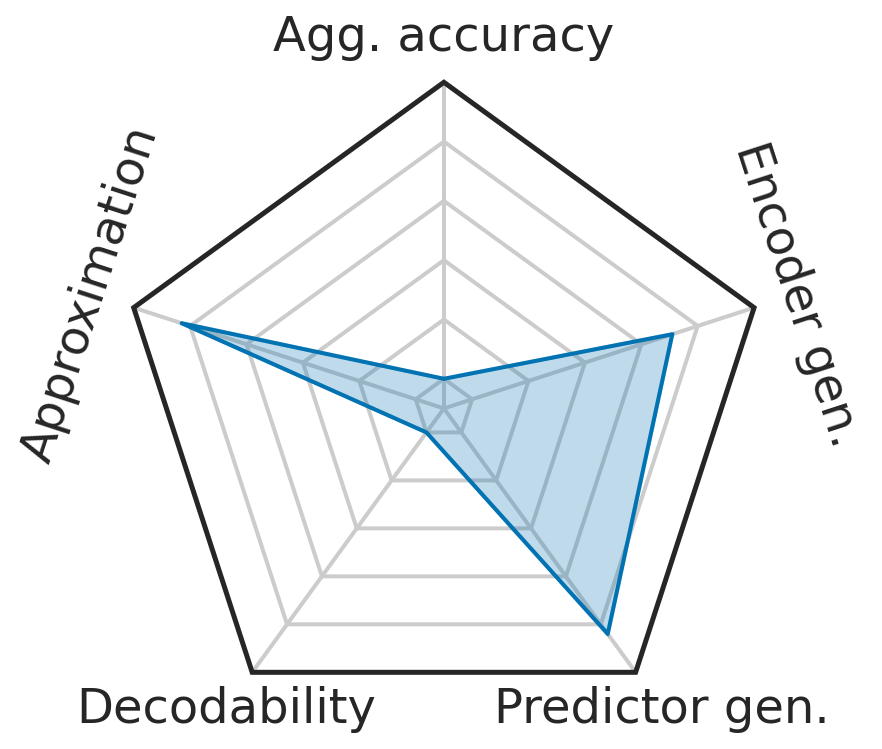

BEIT ViT-L/16


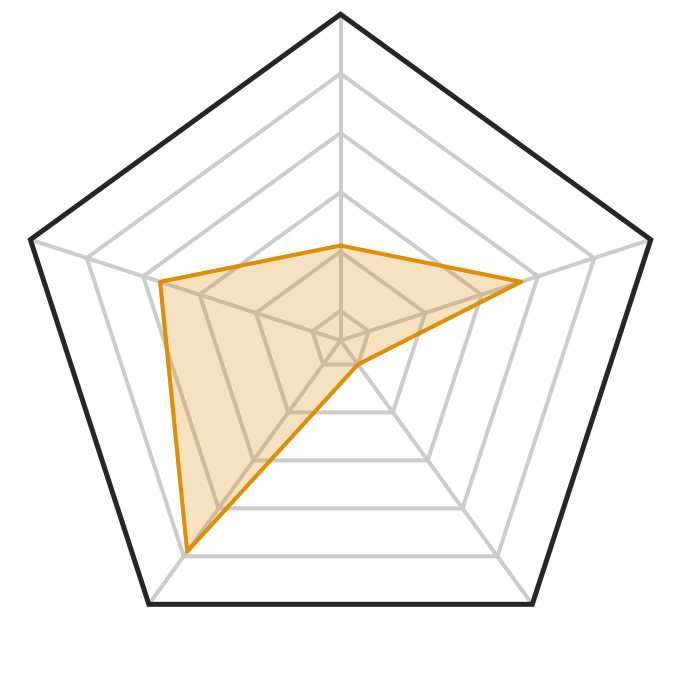

clusterfit RN50


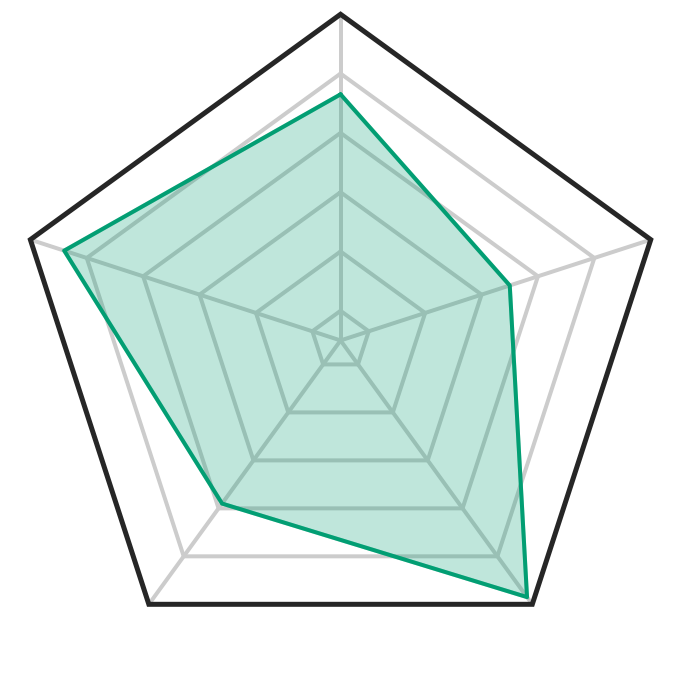

SimCLR RN50w2


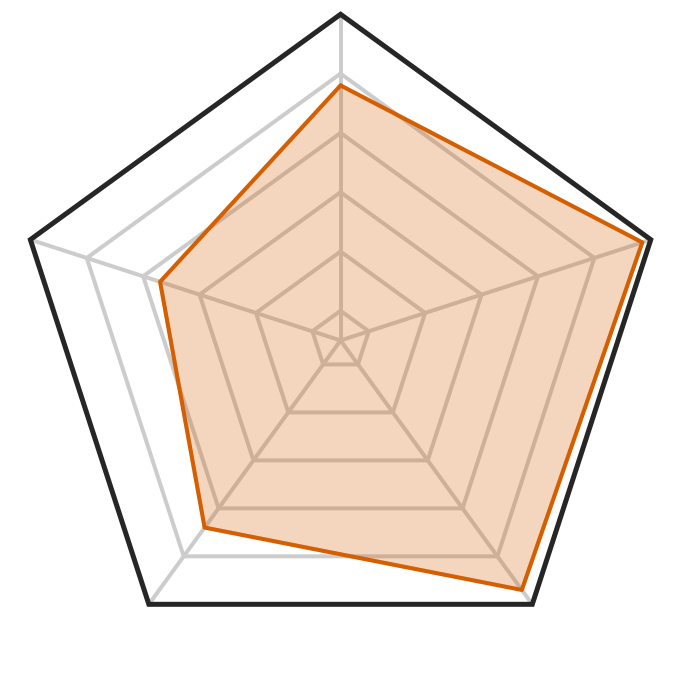

CLIP RN50


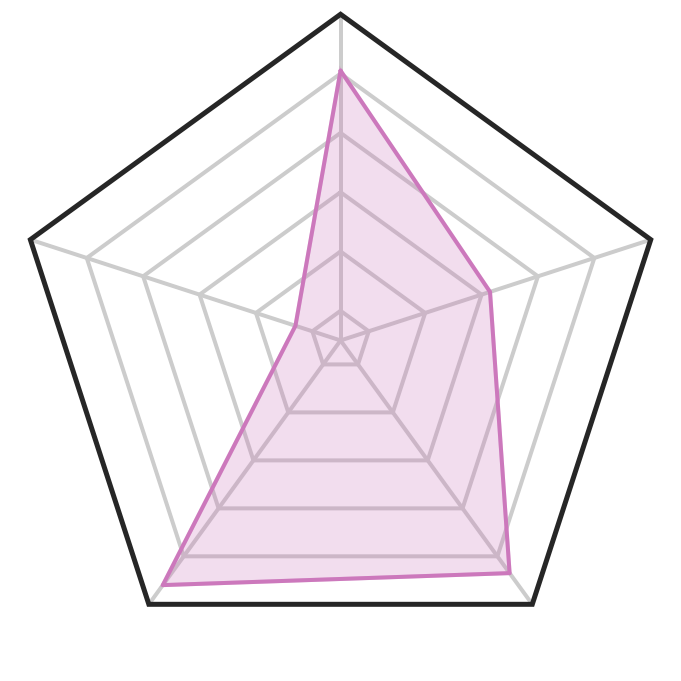

DINO ViT-S/16


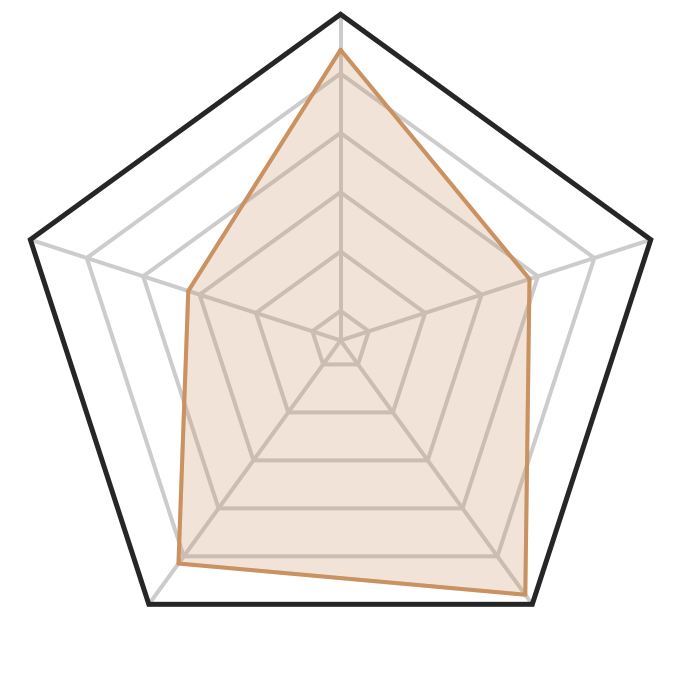

DINO ViT-B/8


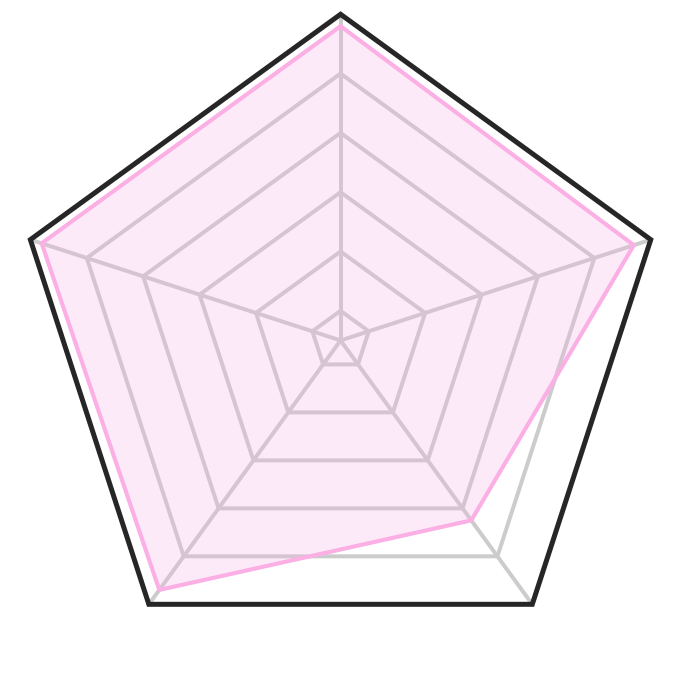

CLIP ViT-L/14


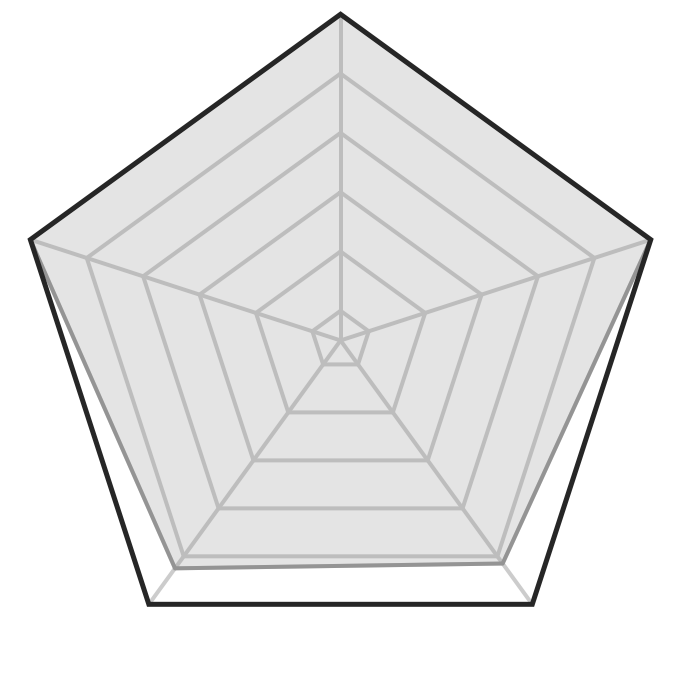

CLIP RN50x64


<Figure size 432x288 with 0 Axes>

In [151]:
with plot_config(font_scale=1, context='poster',):
    plot_radar(results_mean, min_max="pre_select", is_label=False, models=curr_idx_all, components=components)

# Less data

should show large table with most improtant architectues in the 0.01 and in the 1 setting , and show that loss components ordering change very little but aggregated change a lot => can ber used to say when models are better

rerun once finish eval, should show that mostly pred gen changes

### General

In [101]:
base_models = ["simclr_rn50w2","beit_vitL16","clip_vitL14","clusterfit_rn50","swav_rn50","rotnet_rn50_in1k","rotnet_rn50_in22k","clip_rn50","clip_rn50x64"] 
curr_idx = [(m, base_pred) for m in base_models] + [("dino_vitB8", dino_pred)]
curr_components = components_001
results_001 = results_mean.loc[curr_idx, curr_components].round(decimals=2).sort_values("agg_risk_001", ascending=False)
results_001

,,agg_risk_001,approximation_001,decodability_001,pred_gen_001,enc_gen_001,delta_pred_gen
enc,pred,,,,,,
beit_vitL16,torch_linear_lr0.3_wdec1e-06_ep100_bs256,92.61,2.40,54.57,34.22,1.42,-28.58
rotnet_rn50_in1k,torch_linear_lr0.3_wdec1e-06_ep100_bs256,87.82,6.31,52.43,27.51,1.57,-23.96
rotnet_rn50_in22k,torch_linear_lr0.3_wdec1e-06_ep100_bs256,83.16,6.31,41.33,33.31,2.21,-28.17
clusterfit_rn50,torch_linear_lr0.3_wdec1e-06_ep100_bs256,78.78,6.31,11.67,58.24,2.56,-24.75
swav_rn50,torch_linear_lr0.3_wdec1e-06_ep100_bs256,47.88,6.31,13.05,24.75,3.78,-20.51
clip_rn50,torch_linear_lr0.3_wdec1e-06_ep100_bs256,47.61,6.31,17.39,21.81,2.10,-19.64
simclr_rn50w2,torch_linear_lr0.3_wdec1e-06_ep100_bs256,41.66,1.69,23.04,13.46,3.47,-12.11
dino_vitB8,torch_linear_lr0.001_wdec1e-06_ep100_bs256,37.04,7.70,9.18,15.79,4.37,-14.03
clip_rn50x64,torch_linear_lr0.3_wdec1e-06_ep100_bs256,28.40,0.00,8.25,18.38,1.77,-12.56


In [102]:
results_sem.loc[results_001.index, curr_components].round(decimals=2)

,,agg_risk_001,approximation_001,decodability_001,pred_gen_001,enc_gen_001,delta_pred_gen
enc,pred,,,,,,
beit_vitL16,torch_linear_lr0.3_wdec1e-06_ep100_bs256,0.01,0.0,0.00,0.02,0.01,0.14
rotnet_rn50_in1k,torch_linear_lr0.3_wdec1e-06_ep100_bs256,0.11,0.0,0.01,0.03,0.09,0.08
rotnet_rn50_in22k,torch_linear_lr0.3_wdec1e-06_ep100_bs256,0.18,0.0,0.00,0.03,0.16,0.03
clusterfit_rn50,torch_linear_lr0.3_wdec1e-06_ep100_bs256,0.11,0.0,0.00,0.11,0.06,0.09
swav_rn50,torch_linear_lr0.3_wdec1e-06_ep100_bs256,0.17,0.0,0.00,0.10,0.11,0.12
clip_rn50,torch_linear_lr0.3_wdec1e-06_ep100_bs256,0.03,0.0,0.00,0.04,0.03,0.03
simclr_rn50w2,torch_linear_lr0.3_wdec1e-06_ep100_bs256,0.06,0.0,0.00,0.08,0.03,0.13
dino_vitB8,torch_linear_lr0.001_wdec1e-06_ep100_bs256,0.13,0.0,0.01,0.12,0.01,0.12
clip_rn50x64,torch_linear_lr0.3_wdec1e-06_ep100_bs256,0.15,0.0,0.00,0.04,0.14,0.09


### Algorithms

In [103]:
curr_components = components_001
curr_models = [m for m in all_models if m.endswith("_rn50")]  + ['rotnet_rn50_in1k']
curr_idx = [(m,base_pred) for m in curr_models]

results_001_alg = (results_mean.loc[curr_idx, curr_components] 
).round(decimals=2).sort_values("agg_risk_001", ascending=False)

results_001_alg

,,agg_risk_001,approximation_001,decodability_001,pred_gen_001,enc_gen_001,delta_pred_gen
enc,pred,,,,,,
jigsaw_rn50,torch_linear_lr0.3_wdec1e-06_ep100_bs256,90.80,6.31,47.91,34.76,1.83,-27.58
rotnet_rn50_in1k,torch_linear_lr0.3_wdec1e-06_ep100_bs256,87.82,6.31,52.43,27.51,1.57,-23.96
npid_rn50,torch_linear_lr0.3_wdec1e-06_ep100_bs256,79.93,6.31,37.28,33.96,2.37,-28.96
clusterfit_rn50,torch_linear_lr0.3_wdec1e-06_ep100_bs256,78.78,6.31,11.67,58.24,2.56,-24.75
npidpp_rn50,torch_linear_lr0.3_wdec1e-06_ep100_bs256,74.32,6.31,31.09,34.23,2.69,-28.47
pirl_rn50,torch_linear_lr0.3_wdec1e-06_ep100_bs256,63.95,6.31,26.28,28.31,3.05,-24.54
simclr_rn50,torch_linear_lr0.3_wdec1e-06_ep100_bs256,51.20,6.31,16.90,24.81,3.19,-19.71
swav_rn50,torch_linear_lr0.3_wdec1e-06_ep100_bs256,47.88,6.31,13.05,24.75,3.78,-20.51
barlow_rn50,torch_linear_lr0.3_wdec1e-06_ep100_bs256,47.83,6.31,15.42,22.47,3.63,-18.19


In [104]:
results_sem.loc[results_001_alg.index, curr_components[::-1]].round(decimals=2)

,,delta_pred_gen,enc_gen_001,pred_gen_001,decodability_001,approximation_001,agg_risk_001
enc,pred,,,,,,
jigsaw_rn50,torch_linear_lr0.3_wdec1e-06_ep100_bs256,0.04,0.08,0.02,0.00,0.0,0.10
rotnet_rn50_in1k,torch_linear_lr0.3_wdec1e-06_ep100_bs256,0.08,0.09,0.03,0.01,0.0,0.11
npid_rn50,torch_linear_lr0.3_wdec1e-06_ep100_bs256,0.10,0.04,0.10,0.01,0.0,0.06
clusterfit_rn50,torch_linear_lr0.3_wdec1e-06_ep100_bs256,0.09,0.06,0.11,0.00,0.0,0.11
npidpp_rn50,torch_linear_lr0.3_wdec1e-06_ep100_bs256,0.07,0.06,0.04,0.01,0.0,0.10
pirl_rn50,torch_linear_lr0.3_wdec1e-06_ep100_bs256,0.08,0.09,0.02,0.01,0.0,0.08
simclr_rn50,torch_linear_lr0.3_wdec1e-06_ep100_bs256,0.10,0.05,0.06,0.00,0.0,0.08
swav_rn50,torch_linear_lr0.3_wdec1e-06_ep100_bs256,0.12,0.11,0.10,0.00,0.0,0.17
barlow_rn50,torch_linear_lr0.3_wdec1e-06_ep100_bs256,0.23,0.03,0.08,0.00,0.0,0.10


### Architecture

In [105]:
curr_components = components_001
curr_models = [m for m in all_models if m.startswith("clip_")]
curr_idx = [(m,base_pred) for m in curr_models]

results_001_arch_clip = (results_mean.loc[curr_idx, curr_components] 
).round(decimals=2).sort_values("agg_risk_001", ascending=False)
results_001_arch_clip

,,agg_risk_001,approximation_001,decodability_001,pred_gen_001,enc_gen_001,delta_pred_gen
enc,pred,,,,,,
clip_rn50,torch_linear_lr0.3_wdec1e-06_ep100_bs256,47.61,6.31,17.39,21.81,2.10,-19.64
clip_rn101,torch_linear_lr0.3_wdec1e-06_ep100_bs256,41.91,4.45,15.40,20.10,1.95,-17.62
clip_vitB32,torch_linear_lr0.3_wdec1e-06_ep100_bs256,40.33,2.31,9.95,26.09,1.98,-15.23
clip_rn50x4,torch_linear_lr0.3_wdec1e-06_ep100_bs256,37.23,0.00,16.35,19.28,1.60,-16.03
clip_vitB16,torch_linear_lr0.3_wdec1e-06_ep100_bs256,34.04,1.08,7.99,23.06,1.91,-13.21
clip_rn50x16,torch_linear_lr0.3_wdec1e-06_ep100_bs256,32.02,0.00,12.65,17.78,1.59,-14.06
clip_rn50x64,torch_linear_lr0.3_wdec1e-06_ep100_bs256,28.40,0.00,8.25,18.38,1.77,-12.56
clip_vitL14,torch_linear_lr0.3_wdec1e-06_ep100_bs256,26.57,0.58,3.12,20.65,2.22,-8.65


In [106]:
curr_components = components_001
curr_models = [m for m in all_models if m.startswith("simclr_")]
curr_idx = [(m,base_pred) for m in curr_models]

results_001_arch_rn = (results_mean.loc[curr_idx, curr_components] 
).round(decimals=2).sort_values("agg_risk_001", ascending=False)
results_001_arch_rn

,,agg_risk_001,approximation_001,decodability_001,pred_gen_001,enc_gen_001,delta_pred_gen
enc,pred,,,,,,
simclr_rn50_bs512_ep100,torch_linear_lr0.3_wdec1e-06_ep100_bs256,67.65,6.31,23.45,35.60,2.28,-27.96
simclr_rn50_bs4096_ep100,torch_linear_lr0.3_wdec1e-06_ep100_bs256,60.58,6.31,25.32,26.33,2.63,-22.43
simclr_rn50_ep200,torch_linear_lr0.3_wdec1e-06_ep100_bs256,56.79,6.31,24.26,23.41,2.81,-20.15
simclr_rn101_ep100,torch_linear_lr0.3_wdec1e-06_ep100_bs256,55.66,4.45,24.00,24.53,2.68,-20.47
simclr_rn50_ep400,torch_linear_lr0.3_wdec1e-06_ep100_bs256,54.23,6.31,24.03,21.12,2.78,-18.66
simclr_rn50_ep800,torch_linear_lr0.3_wdec1e-06_ep100_bs256,52.48,6.31,24.01,19.27,2.89,-17.21
simclr_rn50w2_ep100,torch_linear_lr0.3_wdec1e-06_ep100_bs256,52.24,1.69,25.39,22.26,2.89,-18.87
simclr_rn50,torch_linear_lr0.3_wdec1e-06_ep100_bs256,51.20,6.31,16.90,24.81,3.19,-19.71
simclr_rn101,torch_linear_lr0.3_wdec1e-06_ep100_bs256,45.04,4.45,22.53,14.71,3.34,-13.32


In [107]:
curr_components = components_001
curr_idx = [i for i in results_mean.index if i[0].startswith("dino_") and i[0].endswith("_last")] + [("dino_rn50",base_pred)]

results_001_arch_dino =  (results_mean.loc[curr_idx, curr_components]
).round(decimals=2).sort_values("agg_risk_001", ascending=False)

results_001_arch_dino

,,agg_risk_001,approximation_001,decodability_001,pred_gen_001,enc_gen_001,delta_pred_gen
enc,pred,,,,,,
dino_rn50,torch_linear_lr0.3_wdec1e-06_ep100_bs256,46.44,6.31,11.65,25.15,3.33,-20.11
dino_vitS16_last,torch_linear_lr0.001_wdec1e-06_ep100_bs256,42.10,13.09,5.78,19.68,3.56,-17.10
dino_vitB16_last,torch_linear_lr0.001_wdec1e-06_ep100_bs256,39.42,9.31,9.27,17.03,3.81,-15.02
dino_vitS16_last,torch_linear_lr0.3_wdec1e-06_ep100_bs256,38.29,7.70,7.68,19.14,3.77,-10.20
dino_vitB16_last,torch_linear_lr0.3_wdec1e-06_ep100_bs256,34.63,1.08,7.51,22.42,3.62,-6.90
dino_vitB8_last,torch_linear_lr0.3_wdec1e-06_ep100_bs256,31.90,0.89,5.82,21.09,4.09,-5.46


# Out of distribution